In [1]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging
import torch.nn.functional as F
from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
device = 'cpu'
#device = 'cuda'

/Users/mxyi/opt/miniconda3/envs/wgf/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/mxyi/opt/miniconda3/envs/wgf/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <434426FA-E571-30E9-A322-B79E71E643A7> /Users/mxyi/opt/miniconda3/envs/wgf/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/mxyi/opt/miniconda3/envs/wgf/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 3., 0 + 3.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [3]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        #if clip_denoised and x_t.ndim > 2:
            #x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [4]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion_process = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [5]:
x_data = data_dist.sample([num_paths])
x_noise, traj_forward = diffusion_process.forward_sample(x_data)

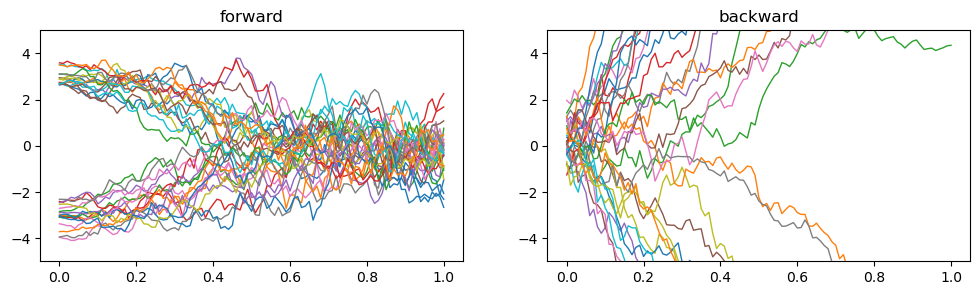

In [6]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion_process.sample(torch.randn([num_paths, 1]).to(device), score_net)
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

In [7]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [8]:
num_epochs = 2500
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths])
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion_process, score_net, t)
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(55.6917, grad_fn=<DivBackward0>)
1 tensor(15.2089, grad_fn=<DivBackward0>)
2 tensor(16.3418, grad_fn=<DivBackward0>)
3 tensor(15.8894, grad_fn=<DivBackward0>)
4 tensor(6.4525, grad_fn=<DivBackward0>)
5 tensor(6.2407, grad_fn=<DivBackward0>)
6 tensor(3.9740, grad_fn=<DivBackward0>)
7 tensor(3.8063, grad_fn=<DivBackward0>)
8 tensor(27.1830, grad_fn=<DivBackward0>)
9 tensor(0.4011, grad_fn=<DivBackward0>)
10 tensor(1.2613, grad_fn=<DivBackward0>)
11 tensor(14.4428, grad_fn=<DivBackward0>)
12 tensor(3.5422, grad_fn=<DivBackward0>)
13 tensor(27.2598, grad_fn=<DivBackward0>)
14 tensor(10.9296, grad_fn=<DivBackward0>)
15 tensor(4.7517, grad_fn=<DivBackward0>)
16 tensor(16.9293, grad_fn=<DivBackward0>)
17 tensor(28.0936, grad_fn=<DivBackward0>)
18 tensor(8.9500, grad_fn=<DivBackward0>)
19 tensor(14.2741, grad_fn=<DivBackward0>)
20 tensor(10.8967, grad_fn=<DivBackward0>)
21 tensor(14.6810, grad_fn=<DivBackward0>)
22 tensor(4.1841, grad_fn=<DivBackward0>)
23 tensor(3.8495, grad_fn=<DivB

194 tensor(3.3081, grad_fn=<DivBackward0>)
195 tensor(7.3680, grad_fn=<DivBackward0>)
196 tensor(19.8705, grad_fn=<DivBackward0>)
197 tensor(1.5526, grad_fn=<DivBackward0>)
198 tensor(5.9515, grad_fn=<DivBackward0>)
199 tensor(4.7857, grad_fn=<DivBackward0>)
200 tensor(2.6568, grad_fn=<DivBackward0>)
201 tensor(10.5354, grad_fn=<DivBackward0>)
202 tensor(21.1358, grad_fn=<DivBackward0>)
203 tensor(1.0429, grad_fn=<DivBackward0>)
204 tensor(5.4832, grad_fn=<DivBackward0>)
205 tensor(6.5572, grad_fn=<DivBackward0>)
206 tensor(0.7494, grad_fn=<DivBackward0>)
207 tensor(6.1561, grad_fn=<DivBackward0>)
208 tensor(0.9497, grad_fn=<DivBackward0>)
209 tensor(0.1448, grad_fn=<DivBackward0>)
210 tensor(4.5286, grad_fn=<DivBackward0>)
211 tensor(9.3765, grad_fn=<DivBackward0>)
212 tensor(0.3445, grad_fn=<DivBackward0>)
213 tensor(1.9024, grad_fn=<DivBackward0>)
214 tensor(144.0527, grad_fn=<DivBackward0>)
215 tensor(7.7085, grad_fn=<DivBackward0>)
216 tensor(10.0879, grad_fn=<DivBackward0>)
217 t

385 tensor(2.3973, grad_fn=<DivBackward0>)
386 tensor(0.3941, grad_fn=<DivBackward0>)
387 tensor(10.7049, grad_fn=<DivBackward0>)
388 tensor(7.6542, grad_fn=<DivBackward0>)
389 tensor(6.9668, grad_fn=<DivBackward0>)
390 tensor(0.5287, grad_fn=<DivBackward0>)
391 tensor(3.7440, grad_fn=<DivBackward0>)
392 tensor(2.3202, grad_fn=<DivBackward0>)
393 tensor(0.4215, grad_fn=<DivBackward0>)
394 tensor(32.3273, grad_fn=<DivBackward0>)
395 tensor(0.5042, grad_fn=<DivBackward0>)
396 tensor(9.3883, grad_fn=<DivBackward0>)
397 tensor(1.9390, grad_fn=<DivBackward0>)
398 tensor(0.3489, grad_fn=<DivBackward0>)
399 tensor(7.9304, grad_fn=<DivBackward0>)
400 tensor(0.3327, grad_fn=<DivBackward0>)
401 tensor(7.6334, grad_fn=<DivBackward0>)
402 tensor(3.5615, grad_fn=<DivBackward0>)
403 tensor(9.7324, grad_fn=<DivBackward0>)
404 tensor(6.3275, grad_fn=<DivBackward0>)
405 tensor(6.8901, grad_fn=<DivBackward0>)
406 tensor(39.4418, grad_fn=<DivBackward0>)
407 tensor(8.8458, grad_fn=<DivBackward0>)
408 tens

582 tensor(29.4268, grad_fn=<DivBackward0>)
583 tensor(1.0295, grad_fn=<DivBackward0>)
584 tensor(4.6859, grad_fn=<DivBackward0>)
585 tensor(2.7842, grad_fn=<DivBackward0>)
586 tensor(0.8573, grad_fn=<DivBackward0>)
587 tensor(1.3728, grad_fn=<DivBackward0>)
588 tensor(7.3311, grad_fn=<DivBackward0>)
589 tensor(1.1269, grad_fn=<DivBackward0>)
590 tensor(0.9177, grad_fn=<DivBackward0>)
591 tensor(4.2153, grad_fn=<DivBackward0>)
592 tensor(3.1199, grad_fn=<DivBackward0>)
593 tensor(4.0765, grad_fn=<DivBackward0>)
594 tensor(4.2330, grad_fn=<DivBackward0>)
595 tensor(4.7573, grad_fn=<DivBackward0>)
596 tensor(0.6669, grad_fn=<DivBackward0>)
597 tensor(0.3309, grad_fn=<DivBackward0>)
598 tensor(0.7776, grad_fn=<DivBackward0>)
599 tensor(1.6087, grad_fn=<DivBackward0>)
600 tensor(0.3469, grad_fn=<DivBackward0>)
601 tensor(3.9894, grad_fn=<DivBackward0>)
602 tensor(51.0584, grad_fn=<DivBackward0>)
603 tensor(2.6995, grad_fn=<DivBackward0>)
604 tensor(84.1702, grad_fn=<DivBackward0>)
605 tens

781 tensor(3.9894, grad_fn=<DivBackward0>)
782 tensor(1.1452, grad_fn=<DivBackward0>)
783 tensor(4.4617, grad_fn=<DivBackward0>)
784 tensor(3.1548, grad_fn=<DivBackward0>)
785 tensor(9.7329, grad_fn=<DivBackward0>)
786 tensor(6.2843, grad_fn=<DivBackward0>)
787 tensor(10.2305, grad_fn=<DivBackward0>)
788 tensor(1.3256, grad_fn=<DivBackward0>)
789 tensor(0.8802, grad_fn=<DivBackward0>)
790 tensor(4.9526, grad_fn=<DivBackward0>)
791 tensor(3.3447, grad_fn=<DivBackward0>)
792 tensor(1.9111, grad_fn=<DivBackward0>)
793 tensor(4.4428, grad_fn=<DivBackward0>)
794 tensor(0.5978, grad_fn=<DivBackward0>)
795 tensor(9.7790, grad_fn=<DivBackward0>)
796 tensor(5.5792, grad_fn=<DivBackward0>)
797 tensor(0.7228, grad_fn=<DivBackward0>)
798 tensor(1.1361, grad_fn=<DivBackward0>)
799 tensor(2.0482, grad_fn=<DivBackward0>)
800 tensor(8.4510, grad_fn=<DivBackward0>)
801 tensor(1.8033, grad_fn=<DivBackward0>)
802 tensor(19.5154, grad_fn=<DivBackward0>)
803 tensor(3.0129, grad_fn=<DivBackward0>)
804 tenso

972 tensor(0.4865, grad_fn=<DivBackward0>)
973 tensor(0.1238, grad_fn=<DivBackward0>)
974 tensor(3.7082, grad_fn=<DivBackward0>)
975 tensor(20.0787, grad_fn=<DivBackward0>)
976 tensor(5.9190, grad_fn=<DivBackward0>)
977 tensor(2.5928, grad_fn=<DivBackward0>)
978 tensor(2.7407, grad_fn=<DivBackward0>)
979 tensor(1.1093, grad_fn=<DivBackward0>)
980 tensor(0.5051, grad_fn=<DivBackward0>)
981 tensor(2.3033, grad_fn=<DivBackward0>)
982 tensor(5.5859, grad_fn=<DivBackward0>)
983 tensor(0.4428, grad_fn=<DivBackward0>)
984 tensor(43.2257, grad_fn=<DivBackward0>)
985 tensor(28.3816, grad_fn=<DivBackward0>)
986 tensor(2.5863, grad_fn=<DivBackward0>)
987 tensor(4.4729, grad_fn=<DivBackward0>)
988 tensor(4.5222, grad_fn=<DivBackward0>)
989 tensor(3.2980, grad_fn=<DivBackward0>)
990 tensor(9.4170, grad_fn=<DivBackward0>)
991 tensor(1.4920, grad_fn=<DivBackward0>)
992 tensor(14.8604, grad_fn=<DivBackward0>)
993 tensor(1.1226, grad_fn=<DivBackward0>)
994 tensor(2.0129, grad_fn=<DivBackward0>)
995 ten

1160 tensor(2.7749, grad_fn=<DivBackward0>)
1161 tensor(6.8131, grad_fn=<DivBackward0>)
1162 tensor(15.2929, grad_fn=<DivBackward0>)
1163 tensor(5.6960, grad_fn=<DivBackward0>)
1164 tensor(30.1519, grad_fn=<DivBackward0>)
1165 tensor(0.7684, grad_fn=<DivBackward0>)
1166 tensor(95.7757, grad_fn=<DivBackward0>)
1167 tensor(2.2904, grad_fn=<DivBackward0>)
1168 tensor(68.0036, grad_fn=<DivBackward0>)
1169 tensor(34.2003, grad_fn=<DivBackward0>)
1170 tensor(0.6042, grad_fn=<DivBackward0>)
1171 tensor(0.7152, grad_fn=<DivBackward0>)
1172 tensor(5.7909, grad_fn=<DivBackward0>)
1173 tensor(4.9389, grad_fn=<DivBackward0>)
1174 tensor(3.2324, grad_fn=<DivBackward0>)
1175 tensor(1.1218, grad_fn=<DivBackward0>)
1176 tensor(5.3146, grad_fn=<DivBackward0>)
1177 tensor(1.0706, grad_fn=<DivBackward0>)
1178 tensor(3.2260, grad_fn=<DivBackward0>)
1179 tensor(4.1662, grad_fn=<DivBackward0>)
1180 tensor(1.7275, grad_fn=<DivBackward0>)
1181 tensor(3.3239, grad_fn=<DivBackward0>)
1182 tensor(1.1769, grad_fn

1347 tensor(2.3330, grad_fn=<DivBackward0>)
1348 tensor(31.4117, grad_fn=<DivBackward0>)
1349 tensor(0.4321, grad_fn=<DivBackward0>)
1350 tensor(17.3453, grad_fn=<DivBackward0>)
1351 tensor(9.2187, grad_fn=<DivBackward0>)
1352 tensor(0.4958, grad_fn=<DivBackward0>)
1353 tensor(21.9571, grad_fn=<DivBackward0>)
1354 tensor(0.8779, grad_fn=<DivBackward0>)
1355 tensor(6.0222, grad_fn=<DivBackward0>)
1356 tensor(5.0136, grad_fn=<DivBackward0>)
1357 tensor(0.1645, grad_fn=<DivBackward0>)
1358 tensor(0.8133, grad_fn=<DivBackward0>)
1359 tensor(1.8095, grad_fn=<DivBackward0>)
1360 tensor(0.1205, grad_fn=<DivBackward0>)
1361 tensor(7.5599, grad_fn=<DivBackward0>)
1362 tensor(4.4198, grad_fn=<DivBackward0>)
1363 tensor(0.7852, grad_fn=<DivBackward0>)
1364 tensor(6.8085, grad_fn=<DivBackward0>)
1365 tensor(0.2855, grad_fn=<DivBackward0>)
1366 tensor(4.6272, grad_fn=<DivBackward0>)
1367 tensor(2.9497, grad_fn=<DivBackward0>)
1368 tensor(34.0853, grad_fn=<DivBackward0>)
1369 tensor(1.4148, grad_fn=

1535 tensor(2.0595, grad_fn=<DivBackward0>)
1536 tensor(0.5223, grad_fn=<DivBackward0>)
1537 tensor(3.8277, grad_fn=<DivBackward0>)
1538 tensor(21.1328, grad_fn=<DivBackward0>)
1539 tensor(11.9482, grad_fn=<DivBackward0>)
1540 tensor(0.7502, grad_fn=<DivBackward0>)
1541 tensor(0.7941, grad_fn=<DivBackward0>)
1542 tensor(21.0727, grad_fn=<DivBackward0>)
1543 tensor(5.9022, grad_fn=<DivBackward0>)
1544 tensor(0.0788, grad_fn=<DivBackward0>)
1545 tensor(0.1971, grad_fn=<DivBackward0>)
1546 tensor(1.6150, grad_fn=<DivBackward0>)
1547 tensor(6.6119, grad_fn=<DivBackward0>)
1548 tensor(10.1622, grad_fn=<DivBackward0>)
1549 tensor(1.2782, grad_fn=<DivBackward0>)
1550 tensor(1.4786, grad_fn=<DivBackward0>)
1551 tensor(3.4729, grad_fn=<DivBackward0>)
1552 tensor(0.6167, grad_fn=<DivBackward0>)
1553 tensor(2.2824, grad_fn=<DivBackward0>)
1554 tensor(3.6288, grad_fn=<DivBackward0>)
1555 tensor(1.1306, grad_fn=<DivBackward0>)
1556 tensor(3.2511, grad_fn=<DivBackward0>)
1557 tensor(0.3877, grad_fn=

1729 tensor(7.4249, grad_fn=<DivBackward0>)
1730 tensor(46.0948, grad_fn=<DivBackward0>)
1731 tensor(10.5096, grad_fn=<DivBackward0>)
1732 tensor(4.6962, grad_fn=<DivBackward0>)
1733 tensor(16.7228, grad_fn=<DivBackward0>)
1734 tensor(16.2113, grad_fn=<DivBackward0>)
1735 tensor(0.8874, grad_fn=<DivBackward0>)
1736 tensor(3.1693, grad_fn=<DivBackward0>)
1737 tensor(17.4405, grad_fn=<DivBackward0>)
1738 tensor(0.3020, grad_fn=<DivBackward0>)
1739 tensor(15.1259, grad_fn=<DivBackward0>)
1740 tensor(4.1819, grad_fn=<DivBackward0>)
1741 tensor(0.3168, grad_fn=<DivBackward0>)
1742 tensor(1.6290, grad_fn=<DivBackward0>)
1743 tensor(5.5544, grad_fn=<DivBackward0>)
1744 tensor(41.4077, grad_fn=<DivBackward0>)
1745 tensor(3.6954, grad_fn=<DivBackward0>)
1746 tensor(16.4591, grad_fn=<DivBackward0>)
1747 tensor(1.8181, grad_fn=<DivBackward0>)
1748 tensor(11.9499, grad_fn=<DivBackward0>)
1749 tensor(0.5536, grad_fn=<DivBackward0>)
1750 tensor(9.3041, grad_fn=<DivBackward0>)
1751 tensor(0.3332, gra

1919 tensor(3.6059, grad_fn=<DivBackward0>)
1920 tensor(2.2152, grad_fn=<DivBackward0>)
1921 tensor(0.3646, grad_fn=<DivBackward0>)
1922 tensor(2.4541, grad_fn=<DivBackward0>)
1923 tensor(0.8286, grad_fn=<DivBackward0>)
1924 tensor(8.4245, grad_fn=<DivBackward0>)
1925 tensor(0.5646, grad_fn=<DivBackward0>)
1926 tensor(0.4556, grad_fn=<DivBackward0>)
1927 tensor(5.7152, grad_fn=<DivBackward0>)
1928 tensor(11.8303, grad_fn=<DivBackward0>)
1929 tensor(2.1006, grad_fn=<DivBackward0>)
1930 tensor(0.6701, grad_fn=<DivBackward0>)
1931 tensor(0.2485, grad_fn=<DivBackward0>)
1932 tensor(4.7879, grad_fn=<DivBackward0>)
1933 tensor(4.2411, grad_fn=<DivBackward0>)
1934 tensor(1.2933, grad_fn=<DivBackward0>)
1935 tensor(7.0938, grad_fn=<DivBackward0>)
1936 tensor(12.1053, grad_fn=<DivBackward0>)
1937 tensor(15.2487, grad_fn=<DivBackward0>)
1938 tensor(38.1067, grad_fn=<DivBackward0>)
1939 tensor(0.3324, grad_fn=<DivBackward0>)
1940 tensor(13.1366, grad_fn=<DivBackward0>)
1941 tensor(38.7863, grad_f

2108 tensor(2.1916, grad_fn=<DivBackward0>)
2109 tensor(3.0689, grad_fn=<DivBackward0>)
2110 tensor(0.2700, grad_fn=<DivBackward0>)
2111 tensor(0.0670, grad_fn=<DivBackward0>)
2112 tensor(0.7967, grad_fn=<DivBackward0>)
2113 tensor(4.7005, grad_fn=<DivBackward0>)
2114 tensor(0.0818, grad_fn=<DivBackward0>)
2115 tensor(1.7202, grad_fn=<DivBackward0>)
2116 tensor(0.1693, grad_fn=<DivBackward0>)
2117 tensor(6.4283, grad_fn=<DivBackward0>)
2118 tensor(1.6657, grad_fn=<DivBackward0>)
2119 tensor(12.6300, grad_fn=<DivBackward0>)
2120 tensor(79.0470, grad_fn=<DivBackward0>)
2121 tensor(0.9031, grad_fn=<DivBackward0>)
2122 tensor(1.3541, grad_fn=<DivBackward0>)
2123 tensor(5.3976, grad_fn=<DivBackward0>)
2124 tensor(0.3162, grad_fn=<DivBackward0>)
2125 tensor(4.4922, grad_fn=<DivBackward0>)
2126 tensor(0.9542, grad_fn=<DivBackward0>)
2127 tensor(4.2689, grad_fn=<DivBackward0>)
2128 tensor(0.5593, grad_fn=<DivBackward0>)
2129 tensor(2.7225, grad_fn=<DivBackward0>)
2130 tensor(2.5920, grad_fn=<D

2298 tensor(4.2819, grad_fn=<DivBackward0>)
2299 tensor(2.5908, grad_fn=<DivBackward0>)
2300 tensor(0.5822, grad_fn=<DivBackward0>)
2301 tensor(4.7066, grad_fn=<DivBackward0>)
2302 tensor(0.4342, grad_fn=<DivBackward0>)
2303 tensor(4.5228, grad_fn=<DivBackward0>)
2304 tensor(6.1934, grad_fn=<DivBackward0>)
2305 tensor(2.0524, grad_fn=<DivBackward0>)
2306 tensor(0.0781, grad_fn=<DivBackward0>)
2307 tensor(3.9206, grad_fn=<DivBackward0>)
2308 tensor(3.9634, grad_fn=<DivBackward0>)
2309 tensor(3.2369, grad_fn=<DivBackward0>)
2310 tensor(0.1184, grad_fn=<DivBackward0>)
2311 tensor(1.2656, grad_fn=<DivBackward0>)
2312 tensor(7.7366, grad_fn=<DivBackward0>)
2313 tensor(1.0621, grad_fn=<DivBackward0>)
2314 tensor(0.0742, grad_fn=<DivBackward0>)
2315 tensor(1.8173, grad_fn=<DivBackward0>)
2316 tensor(3.1942, grad_fn=<DivBackward0>)
2317 tensor(0.2010, grad_fn=<DivBackward0>)
2318 tensor(0.0806, grad_fn=<DivBackward0>)
2319 tensor(2.6131, grad_fn=<DivBackward0>)
2320 tensor(3.8521, grad_fn=<Div

2491 tensor(9.9255, grad_fn=<DivBackward0>)
2492 tensor(0.3991, grad_fn=<DivBackward0>)
2493 tensor(0.2771, grad_fn=<DivBackward0>)
2494 tensor(7.4459, grad_fn=<DivBackward0>)
2495 tensor(3.1859, grad_fn=<DivBackward0>)
2496 tensor(4.7160, grad_fn=<DivBackward0>)
2497 tensor(4.1783, grad_fn=<DivBackward0>)
2498 tensor(4.9454, grad_fn=<DivBackward0>)
2499 tensor(2.8842, grad_fn=<DivBackward0>)


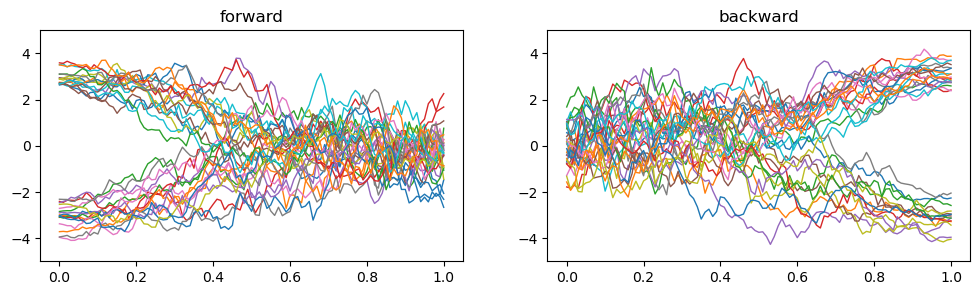

In [12]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion_process.sample(torch.randn([num_paths, 1]).to(device), score_net)
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()